# Importing the necessary libraries

In [80]:
import nltk
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import spacy
import pickle
from wordcloud import WordCloud
# from nltk.stem.wordnet import WordNetLemmatizer
from imblearn.over_sampling import RandomOverSampler
nlp = spacy.load("en_core_web_sm", disable = ["parser", "ner"])
pd.set_option("max_colwidth", None)
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(100)
np.random.seed(100)

Defining functions to save and load pickle files

In [82]:
def pickle_save(obj, name):
  with open(name + ".pkl", "wb") as f:
    pickle.dump(obj, f)

def pickle_load(name):
  with open(name, "rb") as f:
    return pickle.load(f)

# Data Understanding and Cleaning

In [83]:
dataset = pd.read_csv("/content/sample30.csv")
dataset.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


Considering only the columns that we need to solve the problem

In [84]:
data = dataset[["name", "reviews_rating", "reviews_text", "reviews_title", "reviews_username", "user_sentiment"]]
data.sample(5)

,name,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
6102,Red (special Edition) (dvdvideo),5,"Enjoyable, my wife loves watching this movie. Fun, some violence, language not over done in swearing. We watch it again and again.",Fun,xyoung,Positive
2539,Mike Dave Need Wedding Dates (dvd + Digital),5,Funniest movie ever found right away at Best Buy very good deal,Dvd,envygirl,Positive
21576,Nexxus Exxtra Gel Style Creation Sculptor,1,I have been using this product for 20 years and recently went into a store to buy it. I noticed that they had changed the look of the bottle and thought nothing of it. I took it home and used it as I normally would but I noticed that my hair did not stay and it broke half way through the day. This used to be the best gel on the market and now Im not sure what they have done. Also it has a terrible smell like a perfume. I would not recommend buying this product.,Extra Gel,rusty022,Negative
19574,Clorox Disinfecting Bathroom Cleaner,5,I have terrible asthma and allergies and on the occasions that I cannot handle the strong smell of cleaners these wipes work great.,Great for asthma allergies!,yoko76,Positive
12804,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,Love these wipes especially during this time of year This review was collected as part of a promotion.,CLOROX WIPES,couponingnurse82,Positive


In [85]:
print("No of duplicate rows:", data.duplicated().sum())
data.drop_duplicates(inplace= True)
print("Dropped duplicate rows")

No of duplicate rows: 279
Dropped duplicate rows


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29721 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              29721 non-null  object
 1   reviews_rating    29721 non-null  int64 
 2   reviews_text      29721 non-null  object
 3   reviews_title     29531 non-null  object
 4   reviews_username  29658 non-null  object
 5   user_sentiment    29720 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.6+ MB


In [87]:
temp_df = data.loc[~(data["reviews_username"].isnull() | data["user_sentiment"].isnull() | data["reviews_title"].isnull())]
print(f"Percentage of rows containg missing values: {(1 - (temp_df.shape[0] / data.shape[0])) * 100}")

Percentage of rows containg missing values: 0.8512499579421906


Since only 0.85% of rows contain missing values, they are dropped

In [88]:
data = temp_df
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29468 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              29468 non-null  object
 1   reviews_rating    29468 non-null  int64 
 2   reviews_text      29468 non-null  object
 3   reviews_title     29468 non-null  object
 4   reviews_username  29468 non-null  object
 5   user_sentiment    29468 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.6+ MB


Correcting the labels for some of the datapoints

In [89]:
data.loc[(data["user_sentiment"] == "Positive") & (data["reviews_rating"].isin(range(1, 3))), "user_sentiment"] = "Negative"
data.loc[(data["user_sentiment"] == "Negative") & (data["reviews_rating"].isin(range(4, 6))), "user_sentiment"] = "Positive"

Checking for any duplicate rows

In [90]:
data.duplicated().sum()

0

Creating a dataframe review_df from the below 3 columns to built a sentiment analysis model

In [91]:
review_df = data[["reviews_text", "reviews_title", "user_sentiment"]]

Removing duplicate rows from review_df

In [92]:
print(f"The no of duplicate rows: {review_df.duplicated().sum()}")
review_df.drop_duplicates(inplace= True)
print("Removing duplicate rows from review_df")
review_df.sample(5)

The no of duplicate rows: 699
Removing duplicate rows from review_df


,reviews_text,reviews_title,user_sentiment
26787,Great,Great,Positive
15450,So yummy,Love these,Positive
25888,Well I think the west finally got the formula right for a Godzilla movie. They've messed this up for so long is a welcome change to get it right and man was it enjoyable. Reminds of the old days when Godzilla vs anyone would be on on a Saturday afternoon.,Finally a Godzilla movie worth watching,Positive
1084,"I was very disappointed with this shampoo. It didnt give me any volume. In fact it made my hair oily and flat. I lile aussir products but this one just doesn't hold up. I tested Aussie for free, but all opinions are my own.",Unfortunately Flat,Negative
27913,If your kids like the original Cars and Planes they will love this!,Amazing kid movie,Positive


Combining reviews_text and reviews_title into a single attribute

In [93]:

review_df["reviews_text"] = review_df["reviews_text"] + " " + review_df["reviews_title"]
review_df.drop(columns= "reviews_title", inplace= True)
review_df.sample(5)

,reviews_text,user_sentiment
28208,"My family and I love the Disney line movies especially since Cars. This movie is no different in the entertainment area. A must watch for the Kids or the ""Kid"" in you. Great movie",Positive
3780,"This window/door alarm is effective and easy to use. The chime and alarm features are both appropriately loud and will immediately gain one's attention. Installation is easy IF your door is flush with its surrounding framing. If not, you will need to figure out a way to make the alarm and the sensor even with each other. Overall, this is a good, inexpensive alarm. Inexpensive peace of mind",Positive
14296,anything by clorox brand i trust i like the fact that I'm disinfecting my home This review was collected as part of a promotion. clorox a brand i trust,Positive
12231,Love to grab one and wipe off the door knobs throughout the house. This product is quick and easy to use,Positive
5386,Works great and holds all day. I wish it was easier to remove. Mona,Positive


# Data Preprocessing

In [94]:
print(np.sum(review_df["reviews_text"].apply(lambda x: 1 if re.search("this review was collected as part of a promotion.", x.lower()) else 0)))

8488


"this review was collected as part of a promotion." occurs in 8488 reviews. It does not carry information and hence should be discarded

Applying preprocessing techniques on the textual data

In [95]:
def text_preprocessing_1(review):
  unwanted_text = "this review was collected as part of a promotion."
  review = review.lower().replace(unwanted_text, "").strip() # remove the unwanted text and convert the text into its lower_case
  review = re.sub("\.{2,}", " ", review) # remove "....."
  review = re.sub("[^a-z'\s]", "", review) # remove all characters except alphabets, "'", whitespaces
  for ch in string.ascii_lowercase: # reduce strings like "aaaaaaa" and "loooveee" to "a" and "love"
    if ch != "l":
      review = re.sub(f"{ch}" + "{3,}", f"{ch}", review)
    else:
      review = re.sub(f"{ch}" + "{3,}", f"{ch}" + f"{ch}", review)
  return review

text_preprocessing_1 = np.vectorize(text_preprocessing_1)
review_df["reviews_text"] = text_preprocessing_1(review_df["reviews_text"])
review_df.sample(5)

,reviews_text,user_sentiment
17774,the smell is very clean very nice and simple however it does not last as long as i personally like being diabetic i perspire and suffer from bo more than the average person mainly through my feet but also my underarms so i look for deodorants and anti persperant that last long with a clean sent other than that i have only good reviews of this product it does not streak my black under armor it's a solid stick so my armpits don't feal weard after application i would continue use of this product for casual every day use but not for days i know i will be working hard and perspiring as i like to feel and smell as fresh after a hard day of work as when i got out of the shower that morning so to review sent pass clean and not overpowering duration needs improvement does not last as long as i like for a hard labor intensive day application pass goes on easy does not streak and does not iratate the skin or feel awkward great but not perfect,Positive
2189,not only is this movie outrageous and hilarious but the k looks incredible worth it,Positive
11530,a product that truly works on surfaces such as the kitchen bathroom white painted walls etc its so easy when company is coming over just whip out the clorox wipes and its a fast clean up on counter tops bathrrooms and because it is made whith a product that can be trusted it is unbeatable product that is trusted,Positive
15878,excellent for when you still want the bright freshness of the peppermint lip balms but also a little bit of color these are grand in the cold weather months especially it applies smoothly with even color and is rich and plentiful not quite as longlasting as other lipsticks but i still like it the best of both worlds,Positive
25732,great action sequences and plenty of excitement loved it awesome movie,Positive


Convert all words to their lemma form and only retain those words that are neither nouns nor propernouns. Nouns and Proper nouns don't convey much about the sentiment of a review

In [96]:
def text_preprocessing_2(review):
  doc = nlp(review)
  pos_filtered_rev = " ".join([token.lemma_ for token in doc if token.pos_ not in ["PROPN", "NOUN"]])
  return pos_filtered_rev

text_preprocessing_2 = np.vectorize(text_preprocessing_2)
review_df["reviews_text"] = text_preprocessing_2(review_df["reviews_text"])
review_df.sample(5)

,reviews_text,user_sentiment
7029,i love these handy for disinfect just about everything especially during the sick disinfect,Positive
2026,buy this as a for the be a predictable but -PRON- be so funny that -PRON- just go with -PRON- get ready to laugh,Positive
23151,be a little slow at but -PRON- manage to lay all of the for future not just future but other connected as well get to love and kind of slow but a great,Negative
8340,i only use because -PRON- work great on all great,Positive
8602,i use these at and at -PRON- at -PRON- be impressed with the disinfect and great,Positive


Remove stopwords and "-PRON-" string which appeared after lemmatizing the text. Do not remove stopwords like "don't", which convey the sentiment when used in conjunction with certain words ("don't buy", "do not try", "don't like")

In [97]:
stop_words = [word for word in nltk.corpus.stopwords.words("english") if word not in ["don't", "doesn't", "do", "not", "did"]]
def text_preprocessing_3(review):
  review = " ".join([word for word in nltk.tokenize.word_tokenize(review) if word not in stop_words])
  review = review.replace("-PRON-", "")
  return review

text_preprocessing_3 = np.vectorize(text_preprocessing_3)
review_df["reviews_text"] = text_preprocessing_3(review_df["reviews_text"])
review_df.sample(5)

,reviews_text,user_sentiment
5750,give find get blueray cheap entertaining,Positive
14906,love disinfect quick convenient quick,Positive
29222,use along like leave feel without saturate do not feel extremely moisturize give however do not dry anymore already keep clean enough do not wash everyday do say,Positive
9632,like wipe feel free fresh,Positive
14775,good quick easy always best,Positive


In [98]:
print(f"No of duplicate rows: {review_df.duplicated().sum()}")
review_df.drop_duplicates(inplace= True)
review_df.drop_duplicates("reviews_text", inplace=True)
print("Removing duplicate rows")
review_df.sample(5)

No of duplicate rows: 2125
Removing duplicate rows


,reviews_text,user_sentiment
27954,love love great,Positive
3802,allow keep pende wait additional everyday allow yet right,Negative
2203,really think good make laugh whole do recommend funny,Positive
16465,give love tell one good ever buy want different bad say look great never end not go 's make beloved wow even old,Positive
14686,disinfect clean clean,Positive


# EDA

plotting word clouds corresponding to each class of user sentiment

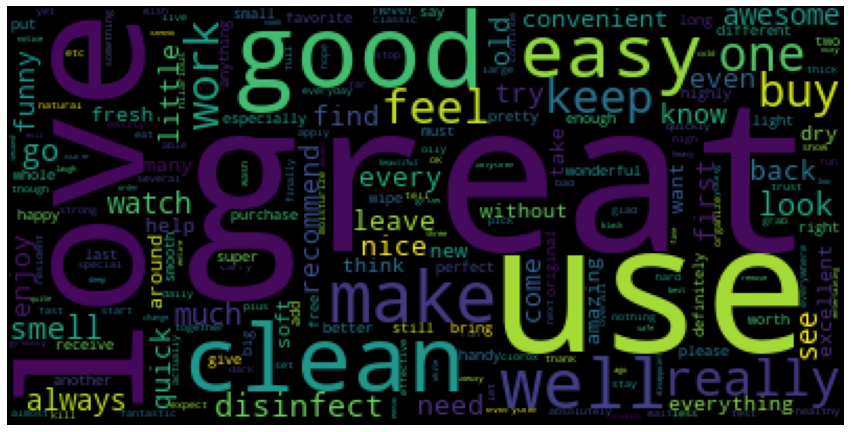

In [99]:
plt.figure(figsize= (15, 10))
word_cloud = WordCloud(collocations= False).generate(" ".join([review for review in review_df[review_df["user_sentiment"] == "Positive"]["reviews_text"]]))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

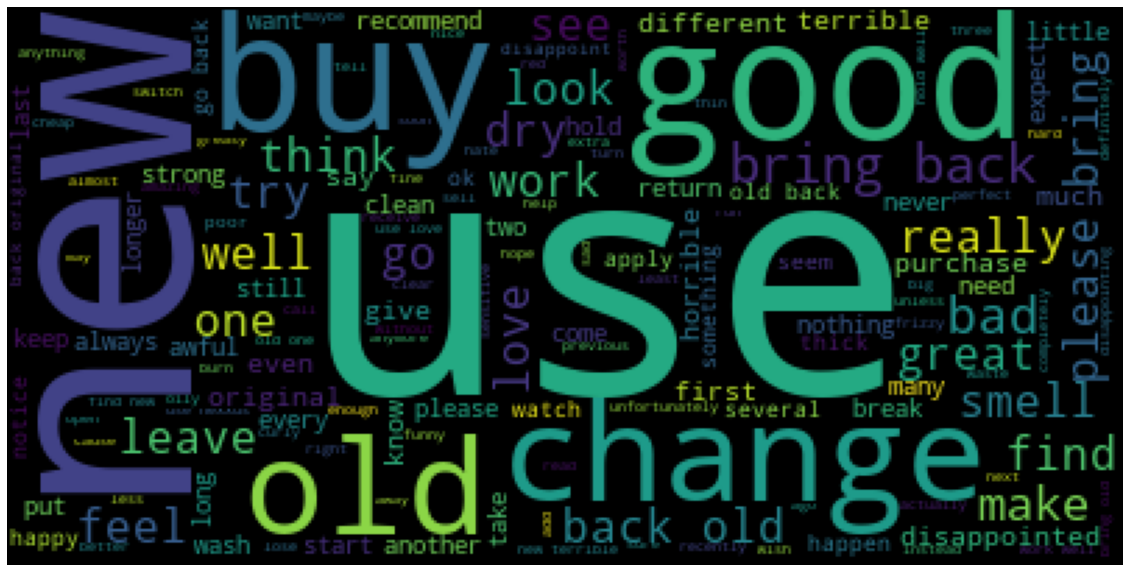

In [100]:
plt.figure(figsize= (20, 15))
word_cloud = WordCloud(collocations= True).generate(" ".join([review for review in review_df[review_df["user_sentiment"] == "Negative"]["reviews_text"]]))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

Plotting the class distribution

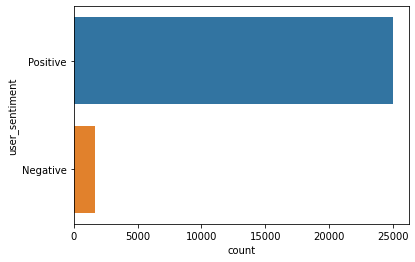

In [101]:
sns.countplot(y = review_df["user_sentiment"])
plt.show()



*   The data provided is highly imbalanced



# Feature Engineering

Converting the target variable into a numerical format 

In [102]:
review_df["user_sentiment"] = review_df["user_sentiment"].map({"Positive": 1, "Negative": 0})
review_df.sample(5)

,reviews_text,user_sentiment
12222,good handy appear work well like,1
5223,first foremost unlike may read do not come digital matter bummed see come really not argue five include progressively get bad numbingly fun would watch great,1
12140,great wish come really good,1
22032,light crisp lather well leave squeeze hard get please change good horrible,1
19932,something keep literally every easy actually clean know finish actually clean clorox easy effective,1


Performing train-test split

In [103]:
X_train, X_test, y_train, y_test = train_test_split(review_df["reviews_text"], review_df["user_sentiment"], test_size= 0.25, random_state= 100, stratify= review_df["user_sentiment"])
print(X_train.shape)
print(X_test.shape)

(19980,)
(6660,)


Applying tf-idf vectorizer to create feature vectors 

In [104]:
vectorizer = TfidfVectorizer(stop_words= stop_words, max_df= 0.95, min_df= 0.05,
                             ngram_range= (1, 3), max_features= 1000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
print(vectorizer.vocabulary_.keys())

dict_keys(['see', 'not', 'do', 'use', 'back', 'good', 'do not', 'buy', 'go', 'would', 'keep', 'look', 'one', 'get', 'great', 'easy', 'disinfect', 'clean', 'easy use', 'recommend', 'also', 'leave', 'well', 'love', 'like', 'smell', 'make', 'watch', 'always', 'really', 'feel', 'awesome', 'work', 'much'])


In [105]:
pickle_save(vectorizer, "tf_idf_vectorizer") # saving the vectorizer as a pickle file

Performing oversampling using a randomoversampler to balance the class distribution

In [106]:
sampler = RandomOverSampler(random_state= 100)
X_train, y_train = sampler.fit_resample(X_train, y_train)

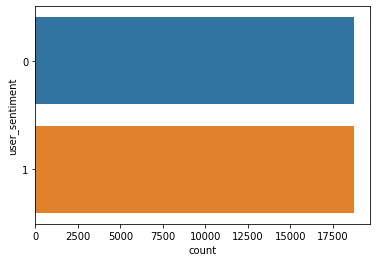

In [107]:
sns.countplot(y= y_train)
plt.show()



*   Class imbalance no longer exists



# Modeling

Defining a function to evaluate the model

In [108]:
def model_pred_eval(model):
  y_train_pred = model.predict(X_train.toarray())
  y_test_pred = model.predict(X_test.toarray())
  print(metrics.accuracy_score(y_train, y_train_pred))
  print(metrics.accuracy_score(y_test, y_test_pred))
  print(metrics.classification_report(y_test, y_test_pred))

Building a logistic regression model

In [109]:
model_1 = LogisticRegression()
model_1.fit(X_train, y_train)

LogisticRegression()

Evaluating the model

In [110]:
model_pred_eval(model_1)

0.8088893626092517
0.7944444444444444
              precision    recall  f1-score   support

           0       0.21      0.85      0.33       406
           1       0.99      0.79      0.88      6254

    accuracy                           0.79      6660
   macro avg       0.60      0.82      0.61      6660
weighted avg       0.94      0.79      0.85      6660



Tuning the hyperparameters of the logistic regression model

In [111]:
param_grid = {
              "C": [0.0001, 0.001, 0.01, 0.1, 1, 10],
              "penalty": ["l1", "l2"],
              "solver" : ["liblinear"]
              }

model_1_tuned = GridSearchCV(estimator= LogisticRegression(), param_grid= param_grid)
model_1_tuned.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

In [112]:
print(model_1_tuned.best_params_)
print(model_1_tuned.best_score_)

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.8100621363890456


In [113]:
model_pred_eval(model_1_tuned)

0.8091291835429546
0.7938438438438439
              precision    recall  f1-score   support

           0       0.21      0.84      0.33       406
           1       0.99      0.79      0.88      6254

    accuracy                           0.79      6660
   macro avg       0.60      0.82      0.61      6660
weighted avg       0.94      0.79      0.84      6660



No change in the performance of the logistic regression model even after tuning its hyper parameters

Building a naive bayes classifier

In [114]:
model_2 = GaussianNB()
model_2.fit(X_train.toarray(), y_train)

GaussianNB()

In [115]:
model_pred_eval(model_2)

0.7744350884672778
0.6642642642642642
              precision    recall  f1-score   support

           0       0.14      0.90      0.25       406
           1       0.99      0.65      0.78      6254

    accuracy                           0.66      6660
   macro avg       0.57      0.78      0.52      6660
weighted avg       0.94      0.66      0.75      6660



The Naive bayes classifier has performed worse when compared to the logistic regression model in terms of accuracy, precision and recall

In [116]:
param_dist = {
                "n_estimators": range(100, 300),
                "min_samples_leaf": range(2, 5),
                "max_depth": range(4, 9)
}

model_3 = RandomizedSearchCV(estimator= RandomForestClassifier(), param_distributions= param_dist, scoring= "accuracy",
                       cv= 4, n_jobs= -1, verbose= 1, random_state= 100)
model_3.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': range(4, 9),
                                        'min_samples_leaf': range(2, 5),
                                        'n_estimators': range(100, 300)},
                   random_state=100, scoring='accuracy', verbose=1)

In [117]:
print(model_3.best_params_)
print(model_3.best_score_)

{'n_estimators': 140, 'min_samples_leaf': 4, 'max_depth': 8}
0.8236783201875932


In [118]:
model_pred_eval(model_3)

0.8286346194841185
0.8400900900900901
              precision    recall  f1-score   support

           0       0.24      0.76      0.37       406
           1       0.98      0.85      0.91      6254

    accuracy                           0.84      6660
   macro avg       0.61      0.80      0.64      6660
weighted avg       0.94      0.84      0.88      6660



In [119]:
pickle_save(model_3, "sentiment_model") # save the randomforest model as a pickle file

# Recommendation System

Creating a dataframe ratings_df using the below 3 attributes to build a recommendation engine

In [120]:
ratings_df = data[["name", "reviews_username", "reviews_rating"]]
ratings_df.sample(5)

,name,reviews_username,reviews_rating
29117,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,embayn5,4
1881,Mike Dave Need Wedding Dates (dvd + Digital),drew2528,3
499,Olay Regenerist Deep Hydration Regenerating Cream,petals66,5
9838,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,shay1026,5
22540,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,rlop,3


Removing any duplicate entries

In [121]:
ratings_df.drop_duplicates(inplace= True)
ratings_df.drop_duplicates(["name", "reviews_username"], inplace=True)

Splitting the data into train and test

In [122]:
train_data, test_data = train_test_split(ratings_df, test_size= 0.25, random_state= 100)
print(train_data.shape)
print(test_data.shape)

(20552, 3)
(6851, 3)


## User based collaborative filtering

Creating a user-item matrix from the train data

In [123]:
user_item_train_df = train_data.pivot(index= "reviews_username", columns= "name", values= "reviews_rating").fillna(0)
user_item_train_df.sample(5)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
nathie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anneky,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mandyc1214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
clonas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fierykim25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


centering the user vectors to measure adjusted cosine similarity

In [124]:
centered_user_item_df = user_item_train_df - np.nanmean(user_item_train_df, axis= 1).reshape((user_item_train_df.shape[0], 1))
centered_user_item_df.sample(5)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
tuna629,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,...,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661
jpkp26,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,...,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661
mlmm,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,...,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661
fullove525,-0.016529,-0.016529,-0.016529,-0.016529,-0.016529,-0.016529,-0.016529,-0.016529,-0.016529,-0.016529,...,-0.016529,-0.016529,-0.016529,-0.016529,-0.016529,-0.016529,-0.016529,-0.016529,-0.016529,-0.016529
sandrardz10,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,...,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661,-0.020661


Create a user similarity matrix using adjusted cosine similarity

In [125]:
user_similarity = 1 - metrics.pairwise_distances(centered_user_item_df, metric="cosine")
user_similarity[np.isnan(user_similarity)] = 0
user_similarity[user_similarity <= 0] = 0
user_similarity

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.94855266],
       [0.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.94855266, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

### Evaluating the user based recommendation system

Create a user item matrix for all users common to train and test data

In [126]:
common_user_data = test_data.loc[test_data["reviews_username"].isin(train_data["reviews_username"])]
common_user_df = common_user_data.pivot(index= "reviews_username", columns= "name", values= "reviews_rating")
common_user_df.sample(5)

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),Ambi Complexion Cleansing Bar,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,...,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
chris,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
mglenn3132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aaron,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
techgeek,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
terry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
user_similarity_df = pd.DataFrame(user_similarity, index= user_item_train_df.index,
                                  columns= user_item_train_df.index)
user_similarity_df.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,11111111aaaaaaaaaaaaaaaaa,...,zozo0o,zpalma,zsarah,zsazsa,zt313,zulaa118,zuttle,zwithanx,zyiah4,zzdiane
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.312681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948553
01impala,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
02dakota,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
02deuce,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
0325home,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000


Remove rows and columns from the user similarity matrix corresponding to those users that are not present in the common user item matrix

In [128]:
user_similarity_df = user_similarity_df.loc[user_similarity_df.index.isin(common_user_df.index), user_similarity_df.columns.isin(common_user_df.index)]

create a dummy test to mask those ratings that are not provided by the user

In [129]:
dummy_test = common_user_data.copy()
dummy_test["reviews_rating"] = dummy_test["reviews_rating"].apply(lambda x: 1 if x >= 1 else 0)
dummy_test = dummy_test.pivot(index= "reviews_username", columns= "name", values= "reviews_rating").fillna(0)
dummy_test.head()

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),Ambi Complexion Cleansing Bar,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,...,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Predicting the ratings for products that were previously rated by the user

In [130]:
predictions = np.dot(user_similarity_df, common_user_df.fillna(0))
predictions = np.multiply(predictions, dummy_test)
predictions.sample(5)

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),Ambi Complexion Cleansing Bar,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz",Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,...,Various - Country's Greatest Gospel:Gold Ed (cd),Various - Red Hot Blue:Tribute To Cole Porter (cd),Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
laura,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
preciousmickeyfan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
karen1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pete100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Scaling the predictions to the range (1, 5) for evaluation purposes

In [131]:
scaler = MinMaxScaler(feature_range= (1, 5))
predictions = predictions[predictions > 0]
predictions = scaler.fit_transform(predictions)
predictions

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

Calculate rmse for the user based recommendation system

In [132]:
rmse = (np.sum(np.sum((predictions - common_user_df) ** 2)) / np.sum(~np.isnan(predictions))) ** 0.5
rmse

2.0051409868069365

## Item based collaborative filtering

Create an item user matrix

In [133]:
item_user_train_df = user_item_train_df.T
item_user_train_df.sample(5)

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,11111111aaaaaaaaaaaaaaaaa,...,zozo0o,zpalma,zsarah,zsazsa,zt313,zulaa118,zuttle,zwithanx,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
Kohler 10280-4 Fort Bath Spout With Sculpted Lift Rod and 1/2-in NPT Connection,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Dermalogica Special Cleansing Gel, 8.4oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bisquick Original Pancake And Baking Mix - 40oz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"All,bran Complete Wheat Flakes, 18 Oz.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


centering the item vectors for measuring adjusted cosine similarity

In [134]:
centered_item_user_df = item_user_train_df - np.nanmean(item_user_train_df, axis= 1).reshape(item_user_train_df.shape[0], 1)
centered_item_user_df.sample(5)

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,11111111aaaaaaaaaaaaaaaaa,...,zozo0o,zpalma,zsarah,zsazsa,zt313,zulaa118,zuttle,zwithanx,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
Scooby Doo And The Loch Ness Monster (blu-Ray),-0.001214,-0.001214,-0.001214,-0.001214,-0.001214,-0.001214,-0.001214,-0.001214,-0.001214,-0.001214,...,-0.001214,-0.001214,-0.001214,-0.001214,-0.001214,-0.001214,-0.001214,-0.001214,-0.001214,-0.001214
Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,-0.026699,-0.026699,-0.026699,-0.026699,-0.026699,-0.026699,-0.026699,-0.026699,-0.026699,-0.026699,...,-0.026699,-0.026699,-0.026699,-0.026699,-0.026699,-0.026699,-0.026699,-0.026699,-0.026699,-0.026699
"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",-0.052132,-0.052132,-0.052132,-0.052132,-0.052132,-0.052132,-0.052132,-0.052132,-0.052132,-0.052132,...,-0.052132,-0.052132,-0.052132,-0.052132,-0.052132,-0.052132,-0.052132,-0.052132,-0.052132,-0.052132
Toy Story Kids' Woody Accessory Kit,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,...,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053,-0.000053
Southern Enterprises Archer Fold-Away Home Bar in Walnut,-0.000264,-0.000264,-0.000264,-0.000264,-0.000264,-0.000264,-0.000264,-0.000264,-0.000264,-0.000264,...,-0.000264,-0.000264,-0.000264,-0.000264,-0.000264,-0.000264,-0.000264,-0.000264,-0.000264,-0.000264


calculating the item similarity matrix using adjusted cosine similarity

In [135]:
item_similarity = 1 - metrics.pairwise_distances(centered_item_user_df, metric= "cosine")
item_similarity[np.isnan(item_similarity)] = 0
item_similarity[item_similarity <= 0] = 0
item_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Evaluating the item based recommendation system

The procedure is similar to that of the user based recommendation system

In [136]:
common_item_data = test_data[test_data["name"].isin(train_data["name"])]
common_item_df = common_item_data.pivot(index="name", columns="reviews_username", values="reviews_rating")
common_item_df.sample(5)

reviews_username,00dog3,1085,10ten,1143mom,1234567,1234asdf,123charlie,127726,12cass12,132457,...,zoeellasca,zoeyny,zokhid,zombiegirl22,zooey_57,zowie,zubb,zxcsdfd,zxjki,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
"Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
The Script - No Sound Without Silence (cd),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Various Artists - Choo Choo Soul (cd),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Clambake (dvd),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Care Free Curl Gold Instant Activator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
item_similarity_df = pd.DataFrame(item_similarity, index=item_user_train_df.index, 
                                  columns=item_user_train_df.index)
item_similarity_df.sample(5)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
Heiress (dvd),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
Pantene Pro-V Expert Collection Age Defy Conditioner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00178,0.0,0.0
Mrs. Meyer's Lemon Verbena Surface Scrub,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
Eagle Fat Free Sweetened Condensed Milk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
L'oreal Paris Advanced Hairstyle Boost It High Lift Creation Spray,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [138]:
item_similarity_df = item_similarity_df.loc[item_similarity_df.index.isin(common_item_df.index), item_similarity_df.columns.isin(common_item_df.index)]

In [139]:
dummy_test = common_item_data.copy()
dummy_test["reviews_rating"] = dummy_test["reviews_rating"].apply(lambda x: 1 if x >= 1 else 0)
dummy_test = dummy_test.pivot(index="name", columns="reviews_username", values="reviews_rating").fillna(0)
dummy_test.sample(5)

reviews_username,00dog3,1085,10ten,1143mom,1234567,1234asdf,123charlie,127726,12cass12,132457,...,zoeellasca,zoeyny,zokhid,zombiegirl22,zooey_57,zowie,zubb,zxcsdfd,zxjki,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
There's Something About Mary (dvd),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
predictions = np.dot(item_similarity_df, common_item_df.fillna(0))
predictions = np.multiply(predictions, dummy_test)
predictions.sample(5)

reviews_username,00dog3,1085,10ten,1143mom,1234567,1234asdf,123charlie,127726,12cass12,132457,...,zoeellasca,zoeyny,zokhid,zombiegirl22,zooey_57,zowie,zubb,zxcsdfd,zxjki,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
Sea Gull Lighting Holman One Light Wall/bath Sconce - Brushed Nickel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Cetaphil Gentle Skin Cleanser, 2oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
If A Man Answers (dvd),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Trend Lab Park Nursing Cover - Paisley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Lundberg Wehani Rice, 25lb",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
scaler = MinMaxScaler(feature_range= (1, 5))
predictions = predictions[predictions > 0]
predictions = scaler.fit_transform(predictions)
predictions

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [142]:
rmse = (np.sum(np.sum((predictions - common_item_df) ** 2)) / np.sum(~np.isnan(predictions))) ** 0.5
rmse

3.5998270023346755



It is better to chose the item based recommendation system despite having a slightly higher rmse, for the following reasons
*   There are 20000 users and most of them have rated only a single product. This makes the user based recommendation matix verly large and sparse. Such a recommendation system will not provide good recommendations to the user
*   There are only 200 items in the dataset. Hence the recommendation matrix will be small and dense. This will provide much better recommendations despite having a higher rmse







Create an item based recommendation matrix using the training data. Dummy_train is used to mask those ratings which have been already provided by the user

In [143]:
dummy_train = train_data.copy()
dummy_train["reviews_rating"] = dummy_train["reviews_rating"].apply(lambda x: 0 if x >= 1 else 1 )
dummy_train = dummy_train.pivot(index="name", columns="reviews_username", values="reviews_rating").fillna(1)
dummy_train.sample(5)

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,11111111aaaaaaaaaaaaaaaaa,...,zozo0o,zpalma,zsarah,zsazsa,zt313,zulaa118,zuttle,zwithanx,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
Maranatha No Stir Raw Maple Almond Butter,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Jolly Time Select Premium Yellow Pop Corn,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Cococare 100% Natural Castor Oil,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
The Script - No Sound Without Silence (cd),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [144]:
ratings_predictions = np.dot(item_similarity, item_user_train_df.fillna(0))
ratings_predictions = np.multiply(ratings_predictions, dummy_train)
ratings_predictions.sample(5)

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,11111111aaaaaaaaaaaaaaaaa,...,zozo0o,zpalma,zsarah,zsazsa,zt313,zulaa118,zuttle,zwithanx,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
Little Bedding By Nojo Jungle Dreams 2 Pack Sheet Set,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
Hollywood Beauty Olive Cholesterol,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
"Coty Airspun Face Powder, Translucent Extra Coverage",0.027580,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.050312,0.033306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03209
Various Artists - Choo Choo Soul (cd),0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),0.007165,0.0,0.0,0.0,0.0,0.0,0.013615,0.0,0.0,0.0,...,0.000000,0.028659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


In [145]:
scaler = MinMaxScaler(feature_range= (1, 5))
index = ratings_predictions.index
columns = ratings_predictions.columns
ratings_predictions = ratings_predictions[ratings_predictions > 0]
ratings_predictions = scaler.fit_transform(ratings_predictions)
ratings_predictions = pd.DataFrame(ratings_predictions, index=index,
                                   columns=columns).fillna(0)
ratings_predictions.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,11111111aaaaaaaaaaaaaaaaa,...,zozo0o,zpalma,zsarah,zsazsa,zt313,zulaa118,zuttle,zwithanx,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.232323,1.232323,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,5.0


In [146]:
pickle_save(ratings_predictions, "recommendation_engine") # save the recommendation matrix as a pickle file

# Inferencing

In [147]:
data = dataset[["name", "reviews_text", "reviews_title"]]
data.drop_duplicates(inplace=True)
data = data.loc[~(data["name"].isnull() | data["reviews_text"].isnull() | data["reviews_title"].isnull())]
data["reviews_text"] = data["reviews_text"] + " " + data["reviews_title"]
data.drop(columns="reviews_title", inplace=True)

Enter username of a user from item_user_train_df

In [148]:
user_name = input("Enter user name: ")
recommendation_eng = pickle_load("/content/recommendation_engine.pkl")
predicted_rat = recommendation_eng.loc[:, user_name].sort_values(ascending= False)
top_20_recom = predicted_rat[predicted_rat > 0].iloc[:20].index
print(top_20_recom)

Enter user name: 09mommy11
Index(['All,bran Complete Wheat Flakes, 18 Oz.',
       'Stander Pt Bedcane - Bed Handle',
       'Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1',
       'Stacy's Simply Naked Bagel Chips', 'Kikkoman Soy Sauce, 5fl oz',
       'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
       'CeraVe SA Renewing Cream', 'Maranatha No Stir Raw Maple Almond Butter',
       'Eagle Fat Free Sweetened Condensed Milk',
       'Care Free Curl Gold Instant Activator',
       'Tai Pei Sweet & Sour Chicken'],
      dtype='object', name='name')


These are the top recommendations (atmost 20) for the given username

### Fine-Tuning the recommendations for the given username

In [149]:
recom = pd.DataFrame({"prod_recommendations": top_20_recom})
recom

,prod_recommendations
0,"All,bran Complete Wheat Flakes, 18 Oz."
1,Stander Pt Bedcane - Bed Handle
2,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1
3,Stacy's Simply Naked Bagel Chips
4,"Kikkoman Soy Sauce, 5fl oz"
5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total
6,CeraVe SA Renewing Cream
7,Maranatha No Stir Raw Maple Almond Butter
8,Eagle Fat Free Sweetened Condensed Milk
9,Care Free Curl Gold Instant Activator


In [150]:
tf_idf_vectorizer = pickle_load("/content/tf_idf_vectorizer.pkl")
sent_model = pickle_load("/content/sentiment_model.pkl")

Defining a funtion that returns the percentage of positive reviews asscociated with each of the 20 recommended products

In [151]:
def generate_perc_pos_review(prod_name):
  prod_reviews = data.loc[data["name"] == prod_name, "reviews_text"]
  prod_reviews = pd.Series(text_preprocessing_1(prod_reviews))
  prod_reviews = pd.Series(text_preprocessing_2(prod_reviews))
  prod_reviews = pd.Series(text_preprocessing_3(prod_reviews))
  prod_reviews.drop_duplicates(inplace=True)
  prod_reviews = tf_idf_vectorizer.transform(prod_reviews)
  predictions = sent_model.predict(prod_reviews)
  return np.sum(predictions) / len(predictions)

The top 5 products based on the percentage of positive reviews associated to them are recommended to the user

In [152]:
recom["perc_pos_reviews"] = recom["prod_recommendations"].apply(generate_perc_pos_review)
print(list(recom.sort_values(by="perc_pos_reviews", ascending=False)["prod_recommendations"].iloc[:5]))

['Stander Pt Bedcane - Bed Handle', 'Eagle Fat Free Sweetened Condensed Milk', 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total', "Stacy's Simply Naked Bagel Chips", 'Care Free Curl Gold Instant Activator']
